### Dobule Descent -> Decision Trees and RFs

In [6]:
! pip install pandas numpy matplotlib scikit-learn

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [8]:
! pwd

/home/jovyan/DOUBLE_DESCENT/Scripts


In [9]:
susceptible_dir = "/home/jovyan/DOUBLE_DESCENT/Data/downloaded_susceptible/gunziped_susceptible/csv_susceptible/post_QC_susceptible"

In [10]:
resistant_dir = "/home/jovyan/DOUBLE_DESCENT/Data/downloaded_resistant/gunziped_resistant/csv_converted/post_QC_resistant"

In [11]:
# Function to extract genotype and features from CSV files
def extract_features_from_csv(file_path):
    df = pd.read_csv(file_path)

    # Extract GT (Genotype) field from the last column
    sample_col = df.columns[-1]  # The last column contains sample-specific genotype data
    df[["GT", "DP", "GT_CONF"]] = df[sample_col].str.split(":", expand=True)[[0, 1, 5]]

    # Convert genotype format to numerical values
    genotype_map = {"0/0": 0, "0/1": 1, "1/1": 2}
    df["GT"] = df["GT"].map(genotype_map).fillna(0).astype(int)  # Convert to numeric

    # Convert DP (Depth) and GT_CONF (Confidence) to float
    df["DP"] = pd.to_numeric(df["DP"], errors="coerce").fillna(0)
    df["GT_CONF"] = pd.to_numeric(df["GT_CONF"], errors="coerce").fillna(0)

    # Keep only relevant columns
    return df[["POS", "GT", "DP", "GT_CONF"]]

In [12]:
# Load all susceptible samples
susceptible_data = []
for file in os.listdir(susceptible_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(susceptible_dir, file)
        susceptible_data.append(extract_features_from_csv(file_path))
susceptible_df = pd.concat(susceptible_data, ignore_index=True)
susceptible_df["label"] = 0  # Susceptible label

In [13]:
susceptible_data[:3]

[          POS  GT   DP  GT_CONF
 0        1849   2  318  2441.45
 1        1977   2  303  2369.32
 2        4013   2  352  2660.17
 3        7362   2  295  2321.12
 4        7585   2  322  2482.97
 ...       ...  ..  ...      ...
 1715  4397736   2  323  2488.92
 1716  4398687   2  304  2375.34
 1717  4407588   2  253  2064.35
 1718  4407927   2  288  2278.76
 1719  4408923   2  263  2126.08
 
 [1720 rows x 4 columns],
           POS  GT   DP  GT_CONF
 0        1977   2  260  1994.78
 1        4013   2  262  2006.64
 2        7362   2  252  1947.21
 3        7585   2  259  1988.85
 4        9304   2  251  1941.25
 ...       ...  ..  ...      ...
 1120  4389322   2  207  1674.67
 1121  4392787   2  228  1802.96
 1122  4395613   2  211  1699.26
 1123  4399484   2  249  1929.31
 1124  4401239   2  234  1839.25
 
 [1125 rows x 4 columns],
           POS  GT   DP  GT_CONF
 0        1849   2  282  2013.81
 1        1977   2  293  2075.28
 2        4013   2  219  1652.96
 3        7362   2  

In [14]:
# Load all resistant samples
resistant_data = []
for file in os.listdir(resistant_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(resistant_dir, file)
        resistant_data.append(extract_features_from_csv(file_path))
resistant_df = pd.concat(resistant_data, ignore_index=True)
resistant_df["label"] = 1  # Resistant label

In [15]:
resistant_data[:3]

[          POS  GT  DP  GT_CONF
 0        1849   2  37   350.06
 1        1977   2  54   444.89
 2        4013   2  62   512.24
 3        7362   2  69   555.64
 4        9304   2  70   561.78
 ...       ...  ..  ..      ...
 1838  4405700   2  72   574.02
 1839  4407588   2  80   622.44
 1840  4407620   2  75   592.28
 1841  4407927   2  78   610.41
 1842  4408923   2  78   610.41
 
 [1843 rows x 4 columns],
           POS  GT  DP  GT_CONF
 0        1032   2  53   213.94
 1        1718   2  39   339.13
 2        1977   2  53   427.33
 3        2532   2  19   203.70
 4        4013   2  63   488.01
 ...       ...  ..  ..      ...
 2515  4401400   2  73   547.11
 2516  4407588   2  58   457.89
 2517  4407873   2  63   488.01
 2518  4410386   2  46   383.76
 2519  4411016   2  38   332.66
 
 [2520 rows x 4 columns],
           POS  GT  DP  GT_CONF
 0        1691   2  49   427.60
 1        1849   2  54   459.70
 2        1977   2  72   571.75
 3        3446   2  47   414.61
 4        4013  

In [16]:
# Combine both datasets
data = pd.concat([susceptible_df, resistant_df], ignore_index=True)

In [17]:
data.isna().sum()

POS        0
GT         0
DP         0
GT_CONF    0
label      0
dtype: int64

In [18]:
data.dropna(inplace=True) # Just in case

In [19]:
# Prepare features and labels
X = data.drop(columns=["label"])  # Features
y = data["label"]  # Labels

In [20]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# Experiment: Varying tree depth (Single Decision Tree)
tree_depths = list(range(1, 51))
tree_train_errors = []
tree_test_errors = []

In [22]:
for depth in tree_depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    tree_train_errors.append(mean_squared_error(y_train, tree.predict(X_train)))
    tree_test_errors.append(mean_squared_error(y_test, tree.predict(X_test)))    

In [23]:
# Experiment: Varying number of trees in an ensemble (Random Forest)
num_trees = list(range(1, 201, 10))
rf_train_errors = []
rf_test_errors = []

In [24]:
for n_trees in num_trees:
    rf = RandomForestRegressor(n_estimators=n_trees, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)
    rf_train_errors.append(mean_squared_error(y_train, rf.predict(X_train)))
    rf_test_errors.append(mean_squared_error(y_test, rf.predict(X_test)))

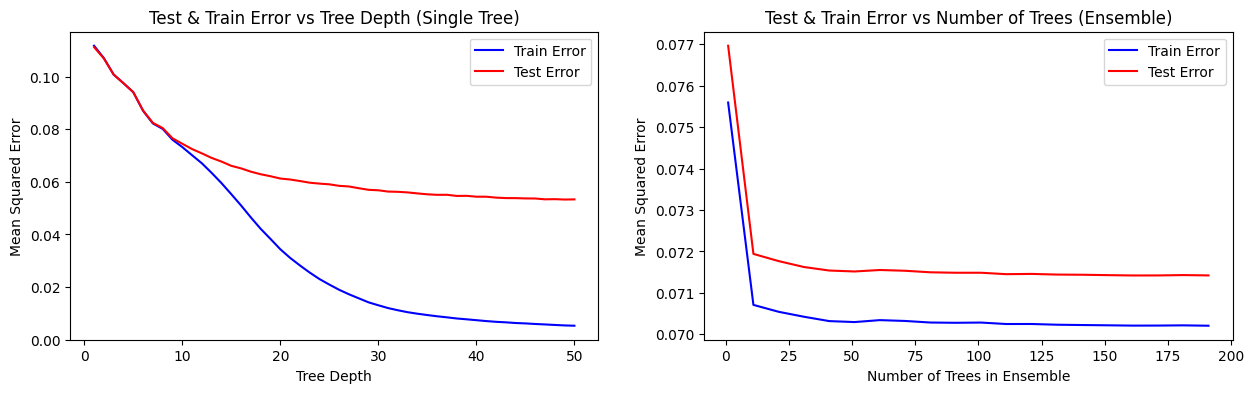

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# Decision Tree Depth vs. MSE
axs[0].plot(tree_depths, tree_train_errors, label="Train Error", color="blue")
axs[0].plot(tree_depths, tree_test_errors, label="Test Error", color="red")
axs[0].set_xlabel("Tree Depth")
axs[0].set_ylabel("Mean Squared Error")
axs[0].set_title("Test & Train Error vs Tree Depth (Single Tree)")
axs[0].legend()

# Random Forest Error Plot (Varying Number of Trees)
axs[1].plot(num_trees, rf_train_errors, label="Train Error", color="blue")
axs[1].plot(num_trees, rf_test_errors, label="Test Error", color="red")
axs[1].set_xlabel("Number of Trees in Ensemble")
axs[1].set_ylabel("Mean Squared Error")
axs[1].set_title("Test & Train Error vs Number of Trees (Ensemble)")
axs[1].legend()

plt.savefig("CRyPTIC_double_descent.png", dpi=300)
plt.show()

In [28]:
# Compute accuracy, recall, and precision 
# for appendix
# do the boosting algorithm 